In [1]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK
using LinearAlgebra
using TabularTDLearning         # Q‑Learning & SARSA solvers
using POMDPTools: EpsGreedyPolicy, DiscreteBelief

In [2]:
println("HELLO WORLD ")

HELLO WORLD 


### Description théorique du MDP

- **États** : triplet \((s_1, s_2, s_w)\) où :
  - \(s_1\), \(s_2\) : stock des magasins 1 et 2 (0 à 20),
  - \(s_w\) : stock de l'entrepôt (0 à 20).

- **Actions** : \((a_1, a_2) \in \{0,1\}^2\)
  - \(a_1\) : commander (1) ou ne pas commander (0) pour magasin 1,
  - \(a_2\) : commander (1) ou ne pas commander (0) pour magasin 2.

- **Transitions** :
  - Commande : 5 vélos par magasin si possible selon la capacité,
  - Demande aléatoire \(d_1, d_2 \sim \text{Uniform}(0,7)\),
  - Livraison directe ou livraison à domicile depuis l'entrepôt,
  - Réapprovisionnement automatique de l'entrepôt si \(s_w < 10\).

- **Récompenses** :
  - Coût de commande : 20€ par commande,
  - Coûts de stockage : magasin (2€/vélo), parking extérieur (juste magasin 1) (4€/vélo), entrepôt (1€/vélo),
  - Livraison à domicile : 10€/vélo,
  - Vente perdue (stockout) : pénalité de 50€/vélo non satisfait.

- **Stochasticité** : uniquement sur la demande \(d_1, d_2\).

- **Objectif** : minimiser les coûts totaux sur un horizon infini (\(\gamma=0.99\)).



In [3]:


### Définir le MDP corrigé EddyBikes ###
const MAX_INVENTORY = 20
const MAX_STORE = 10
const ORDER_SIZE = 5
const REPLENISH_WAREHOUSE_BATCH = 10

const holding_cost_store = 2
const holding_cost_parking = 4
const holding_cost_warehouse = 1
const order_cost = 20
const home_delivery_cost = 10
const stockout_penalty = 50

const demand_dist = DiscreteUniform(0, 7)

mdp = QuickMDP(
    states = [(s1, s2, sw) for s1 in 0:MAX_INVENTORY, s2 in 0:MAX_INVENTORY, sw in 0:MAX_INVENTORY],
    actions = [(a1, a2, aw) for a1 in 0:1, a2 in 0:1, aw in 0:1],
    discount = 0.99,

    gen = function (s, a, rng)
        s1, s2, sw = s

        a1, a2, aw = a

        # --- Réapprovisionnement usine vers warehouse ---
        new_sw = sw + (aw == 1 ? REPLENISH_WAREHOUSE_BATCH : 0)
        new_sw = min(new_sw, MAX_INVENTORY)

        # --- Commandes magasins ---
        order1 = a1 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s1) : 0
        order2 = a2 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s2) : 0

        total_requested = order1 + order2

        if total_requested <= new_sw
            actual_order1, actual_order2 = order1, order2
        else
            if s1 < s2
                actual_order1 = min(order1, new_sw)
                actual_order2 = new_sw - actual_order1
            else
                actual_order2 = min(order2, new_sw)
                actual_order1 = new_sw - actual_order2
            end
        end

        actual_order1 = min(actual_order1, ORDER_SIZE)
        actual_order2 = min(actual_order2, ORDER_SIZE)

        new_s1 = s1 + actual_order1
        new_s2 = s2 + actual_order2
        new_sw -= (actual_order1 + actual_order2)

        # --- Demandes clients ---
        d1 = rand(rng, demand_dist)
        d2 = rand(rng, demand_dist)

        sold1 = min(new_s1, d1)
        remaining_demand1 = d1 - sold1
        delivered1 = min(remaining_demand1, new_sw)
        lost_sales1 = remaining_demand1 - delivered1

        new_s1 -= sold1
        new_sw -= delivered1

        sold2 = min(new_s2, d2)
        remaining_demand2 = d2 - sold2
        delivered2 = min(remaining_demand2, new_sw)
        lost_sales2 = remaining_demand2 - delivered2

        new_s2 -= sold2
        new_sw -= delivered2

        # --- Coûts ---
        cost = 0
        cost += (a1 == 1 ? order_cost : 0) + (a2 == 1 ? order_cost : 0)
        #cost += (aw == 1 ? order_cost : 0)

        in_store1 = min(new_s1, MAX_STORE)
        in_parking1 = max(new_s1 - MAX_STORE, 0)
        cost += in_store1 * holding_cost_store + in_parking1 * holding_cost_parking

        cost += new_s2 * holding_cost_store
        cost += new_sw * holding_cost_warehouse
        cost += (delivered1 + delivered2) * home_delivery_cost
        cost += (lost_sales1 + lost_sales2) * stockout_penalty

        r = -cost
        total_demand = d1 + d2
        served       = sold1 + sold2              # bought directly in shops
        express      = delivered1 + delivered2    # home deliveries
        lost         = lost_sales1 + lost_sales2   # unmet demand

        # reward is still negative cost
        # r = -cost

        return (
            sp      = (new_s1, new_s2, new_sw),   # next state
            r       = r,                          # reward
            demand  = total_demand,               #   ↓  extra outputs
            served  = served,
            express = express,
            lost    = lost,
        )
        # return (sp = (new_s1, new_s2, new_sw), r = r, d = (d1, d2))
        # return ((new_s1, new_s2, new_sw), r)
    end,

    initialstate = Deterministic((10, 10, 10))
)


QuickMDP{Base.UUID("fcde5602-0542-40ff-aff8-b7a198f8309f"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#13#16"}}((stateindex = Dict((19, 5, 6) => 2771, (6, 13, 14) => 6454, (20, 16, 1) => 798, (3, 9, 8) => 3721, (0, 2, 19) => 8422, (16, 15, 16) => 7388, (14, 12, 1) => 708, (11, 13, 15) => 6900, (16, 5, 3) => 1445, (18, 6, 19) => 8524…), isterminal = false, actionindex = Dict((0, 0, 0) => 1, (1, 1, 1) => 8, (1, 1, 0) => 4, (0, 1, 1) => 7, (0, 1, 0) => 3, (1, 0, 1) => 6, (1, 0, 0) => 2, (0, 0, 1) => 5), initialstate = Deterministic{Tuple{Int64, Int64, Int64}}((10, 10, 10)), states = [(0, 0, 0) (0, 1, 0) … (0, 19, 0) (0, 20, 0); (1, 0, 0) (1, 1, 0) … (1, 19, 0) (1, 2

## Optimize the inventory control policy using the Q-learning

In [4]:
global const S = collect(states(mdp))
global const A = collect(actions(mdp))
global const sidx = Dict(s => i for (i,s) in enumerate(S)) # map state  → row
global const aidx = Dict(a => j for (j,a) in enumerate(A)) # map action → col
global ns, na = length(S), length(A)


# N = zeros(Int, 21 * 21 * 21 , 8) 


# N[sidx[(0, 0, 0)], aidx[(0, 1, 0)]] += 100
# N[sidx[(0, 0, 0)], aidx[(0, 1, 0)]]


(9261, 8)

Here we chose our own implementation of the Q-Learning algo over the one from TabularTDLearning, for two main reason (but we also compared both implementation below):
- Control over step-sier $\alpha$ (not fixed)
- Easier to measure the leaning curve


For $\alpha$ we saw by exprimenting that using the **Q-Learning Convergence Theorem (Watkins & Dayan, 1992)**, the algorithm converges better in less iterations than with a fixed step-size (ex: 
using solvers).

The theorem says that: 
- If the MDP is finite
- If the learning rate $\alpha_t(s, a)$ obey the following conditions:
$$\sum_t \alpha_t(s, a) = \infty, \hspace{15mm} \sum_t \alpha_t(s, a)^2 < \infty,\hspace{10mm} \forall (s, a)$$
- The state-action pair is visited $N_t(s,a)$ grows to infinity as t grows to infity for every (s, a) 
- The reward $r_t$ are bounded
  
-> Then 

$$\lim_{t \rightarrow \infty} Q_t(s, a) = Q^*(s, a)$$

with probabilty 1, where the update is:

$$Q_{t + 1}(s_t, a_t) =Q_{t}(s_t, a_t) +  \alpha_t(s_t, a_t) (r_t + \gamma \max_{a'} Q_t(s_{t + 1} , a')  - Q_t(s_t, a_t) ) $$


So, we chose:

$$\alpha_t(s_t, a_t) = \frac{1}{N_t(a, s)}$$

In [8]:
function my_q_learning(mdp;
                       ε::Float64        = 0.1,
                       epochs::Int       = 100,       
                       iterations::Int   = 10_000,   
                       γ::Float64        = discount(mdp),
                       rng::AbstractRNG  = MersenneTwister(0))

    # S = collect(states(mdp))
    # A = collect(actions(mdp))
    # ns, na = length(S), length(A)

    # sidx = Dict(s => i for (i,s) in enumerate(S))
    # aidx = Dict(a => j for (j,a) in enumerate(A))

    Q = zeros(ns, na)
    N = zeros(Int, ns, na)

    err = Float64[]

    for k in 1:iterations
        Q_old = copy(Q)

        for _ in 1:epochs
            
            # s = rand(rng, initialstate(mdp))
            s  = Tuple(rand(0:20, 3))       

            for _ in 1:30                          
                si = sidx[s]

                a = if rand(rng) < ε
                        rand(rng, A)
                    else
                        A[argmax(@view Q[si, :])]
                    end
                ai = aidx[a]

                out = POMDPs.gen(mdp, s, a, rng)
                sp, r = out.sp, out.r
                spi   = sidx[sp]

                N[si, ai] += 1
                α = 1.0 / N[si, ai]
                Q[si, ai] += α * (r + γ * maximum(@view Q[spi, :]) - Q[si, ai])

                s = sp
            end
        end

        if k % 100 == 0
            push!(err, norm(Q - Q_old))
        end
        k % 10000 == 0 && println("iter = $k  ‖ΔQ‖₂ = $(err[end])")
    end

    return Q, err
end

println("Starting ")
Q_l, err = my_q_learning(mdp; ε=0.1, epochs=150, iterations=100_000)
println("Finished.  Final max‑Q for initial state = ",
        maximum(Q_l[sidx[(10,10,10)], :]))


Starting 
iter = 10000  ‖ΔQ‖₂ = 28.9090605969373
iter = 20000  ‖ΔQ‖₂ = 16.073310164436645
iter = 30000  ‖ΔQ‖₂ = 13.480101421522887
iter = 40000  ‖ΔQ‖₂ = 10.533932032959648
iter = 50000  ‖ΔQ‖₂ = 8.341379694912577
iter = 60000  ‖ΔQ‖₂ = 6.046079388030959
iter = 70000  ‖ΔQ‖₂ = 8.293886059115449
iter = 80000  ‖ΔQ‖₂ = 3.310116930987213
iter = 90000  ‖ΔQ‖₂ = 3.9702645216041095
iter = 100000  ‖ΔQ‖₂ = 3.7011968624289433
Finished.  Final max‑Q for initial state = -509.21002258479456


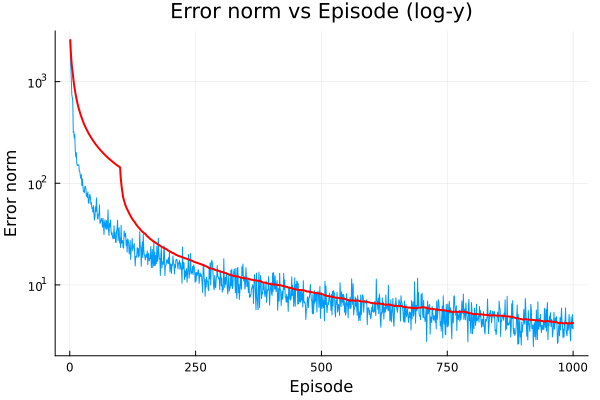

In [9]:
window_size = 100 
moving_avg = [mean(err[max(1, i-window_size+1):i]) for i in 1:length(err)]

plot(
  err,
  xlabel    = "Episode",
  ylabel    = "Error norm",
  title     = "Error norm vs Episode (log‐y)",
  legend    = false,
  yscale    = :log10,       
  # xscale    = :log10,       
)
plot!(moving_avg, label = "Moving average", linewidth = 2, color = :red)

#### ADD COMMENT ON THE PLOT !!!

In [10]:

N_eval = 1000
total_rewards = zeros(N_eval)
n_epoch = 30

greedy_action(s) = A[argmax(@view Q_l[sidx[s], :])]

for k in 1:N_eval
    # s = (10, 10, 10)
    s  = Tuple(rand(0:20, 3))        # start state

    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:n_epoch
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = greedy_action(s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

mean_r = mean(total_rewards) = -1295.8333974327556
std_r = std(total_rewards) = 70.59293130277881


70.59293130277881

## Using solvers

In [11]:
α = 1e-5
ϵ = 0.1
n_episodes = 100_000 *30


ql_solver   = QLearningSolver(
                 exploration_policy = EpsGreedyPolicy(mdp, ϵ),
                 learning_rate      = α,
                 n_episodes         = n_episodes,
                 max_episode_length = 150,
                 eval_every         = Int(n_episodes/10),
                 n_eval_traj        = 100,
                 verbose = false)


res_q = solve(ql_solver, mdp)


ValuePolicy{QuickMDP{Base.UUID("fcde5602-0542-40ff-aff8-b7a198f8309f"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#13#16"}}, Matrix{Float64}, Tuple{Int64, Int64, Int64}}:
 (0, 0, 0) -> (1, 1, 1)
 (1, 0, 0) -> (0, 1, 1)
 (2, 0, 0) -> (1, 1, 1)
 (3, 0, 0) -> (0, 1, 1)
 (4, 0, 0) -> (0, 1, 1)
 (5, 0, 0) -> (1, 1, 1)
 (6, 0, 0) -> (0, 1, 1)
 (7, 0, 0) -> (1, 1, 1)
 (8, 0, 0) -> (0, 0, 1)
 (9, 0, 0) -> (0, 1, 1)
 (10, 0, 0) -> (1, 1, 1)
 (11, 0, 0) -> (0, 0, 1)
 (12, 0, 0) -> (1, 0, 0)
 (13, 0, 0) -> (0, 1, 1)
 (14, 0, 0) -> (0, 0, 1)
 (15, 0, 0) -> (0, 1, 1)
 (16, 0, 0) -> (0, 0, 1)
 (17, 0, 0) -> (0, 1, 0)
 (18, 0, 0) -> (1, 1, 0)
 (19, 0, 0) -> (0, 1, 1)
 …

In [12]:

N_eval = 1000
total_rewards = zeros(N_eval)

for k in 1:N_eval
    s = (10, 10, 10)
    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:15
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = action(res_q, s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        # total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

mean_r = mean(total_rewards) = -851.0649963605948
std_r = std(total_rewards) = 121.8690991528098


121.8690991528098

# SARSA

Here, we use the same ideas from the Q-Leanring but adpated it to to the SARSA update.

In [13]:
@inline function egreedy_action(Qrow, A, ε, rng)
    return rand(rng) < ε ? rand(rng, A) : A[argmax(Qrow)]
end

function my_sarsa(mdp;
                  ε::Float64        = 0.1,
                  epochs::Int       = 100,
                  iterations::Int   = 10_000,
                  γ::Float64        = discount(mdp),
                  rng::AbstractRNG  = MersenneTwister(0))

    # S   = collect(states(mdp));    ns = length(S)
    # A   = collect(actions(mdp));   na = length(A)
    # sidx = Dict(s => i for (i,s) in enumerate(S))
    # aidx = Dict(a => j for (j,a) in enumerate(A))

    Q = zeros(ns, na)      # Q‑table
    N = zeros(Int, ns, na) # visit counters
    err = Float64[]

    for k in 1:iterations
        Q_old = copy(Q)

        for _ in 1:epochs
            # s  = rand(rng, initialstate(mdp))        
            s  = Tuple(rand(0:20, 3))     
            si = sidx[s]
            a  = egreedy_action(view(Q, si, :), A, ε, rng)
            ai = aidx[a]

            for _ in 1:30
                out = POMDPs.gen(mdp, s, a, rng)
                sp, r = out.sp, out.r
                spi   = sidx[sp]

                ap  = egreedy_action(view(Q, spi, :), A, ε, rng)
                api = aidx[ap]

                N[si, ai] += 1;  α = 1.0 / N[si, ai]
                Q[si, ai] += α * (r + γ * Q[spi, api] - Q[si, ai])

                s  = sp;  si = spi;  a = ap;  ai = api
            end
        end

        if k % 100 == 0
            push!(err, norm(Q - Q_old))
        end
        k % 10_000 == 0 && println("iter = $k  ‖ΔQ‖₂ = $(err[end])")
    end
    return Q, err
end

Q_s, errs = my_sarsa(mdp; ε=0.1, epochs=150, iterations=100_000)
S = collect(states(mdp)); sidx = Dict(s => i for (i,s) in enumerate(S))
println("Finished SARSA.  Max‑Q for initial state = ",
        maximum(Q_s[sidx[(10,10,10)], :]))


iter = 10000  ‖ΔQ‖₂ = 27.281207479495382
iter = 20000  ‖ΔQ‖₂ = 14.26515690043737
iter = 30000  ‖ΔQ‖₂ = 8.796103526215102
iter = 40000  ‖ΔQ‖₂ = 7.7051996280935935
iter = 50000  ‖ΔQ‖₂ = 7.417546407642219
iter = 60000  ‖ΔQ‖₂ = 6.245134812037634
iter = 70000  ‖ΔQ‖₂ = 4.706617006973739
iter = 80000  ‖ΔQ‖₂ = 5.482863910815562
iter = 90000  ‖ΔQ‖₂ = 3.963335642925849
iter = 100000  ‖ΔQ‖₂ = 3.301349252077097
Finished SARSA.  Max‑Q for initial state = -539.6301055822217


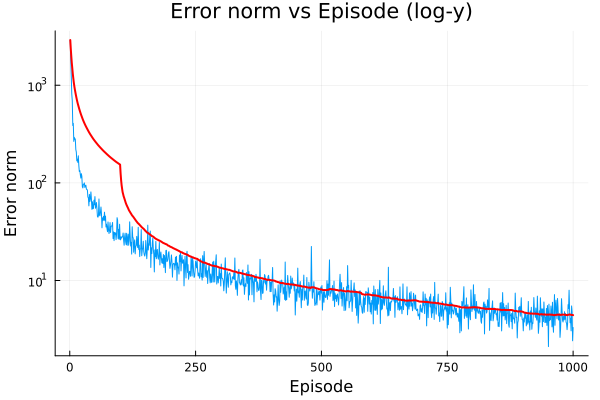

In [14]:
window_size = 100  # choose your smoothing window
moving_avg = [mean(errs[max(1, i-window_size+1):i]) for i in 1:length(errs)]

plot(
  errs,
  xlabel    = "Episode",
  ylabel    = "Error norm",
  title     = "Error norm vs Episode (log‐y)",
  legend    = false,
  yscale    = :log10,       # ◀── here’s the magic
  # xscale    = :log10,       # ◀── here’s the magic
)
plot!(moving_avg, label = "Moving average", linewidth = 2, color = :red)

#### ADD COMMENT ON THE PLOT !!!

In [15]:

N_eval = 1000
total_rewards = zeros(N_eval)
n_epoch = 30

greedy_action(s) = A[argmax(@view Q_s[sidx[s], :])]

for k in 1:N_eval
    # s = (10, 10, 10)
    s = Tuple(rand(1:20, 3))

    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:n_epoch
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = greedy_action(s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

mean_r = mean(total_rewards) = -1341.1503909425896
std_r = std(total_rewards) = 69.608315248328


69.608315248328

## Sarsa solvers

In [16]:
α = 1e-7
ϵ = 0.1
n_episodes = 100_000 * 30



sarsa_solver   = SARSASolver(
    exploration_policy = EpsGreedyPolicy(mdp, ϵ),
    learning_rate      = α,
    n_episodes         = n_episodes,
    max_episode_length = 150,
    eval_every         = 10000,
    n_eval_traj        = 100)


res_s = solve(ql_solver, mdp)

ValuePolicy{QuickMDP{Base.UUID("fcde5602-0542-40ff-aff8-b7a198f8309f"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#13#16"}}, Matrix{Float64}, Tuple{Int64, Int64, Int64}}:
 (0, 0, 0) -> (1, 1, 1)
 (1, 0, 0) -> (0, 1, 1)
 (2, 0, 0) -> (0, 1, 1)
 (3, 0, 0) -> (1, 1, 1)
 (4, 0, 0) -> (0, 1, 1)
 (5, 0, 0) -> (0, 0, 1)
 (6, 0, 0) -> (0, 1, 1)
 (7, 0, 0) -> (0, 1, 1)
 (8, 0, 0) -> (0, 0, 1)
 (9, 0, 0) -> (0, 1, 1)
 (10, 0, 0) -> (0, 1, 1)
 (11, 0, 0) -> (0, 1, 1)
 (12, 0, 0) -> (0, 0, 0)
 (13, 0, 0) -> (0, 1, 1)
 (14, 0, 0) -> (0, 0, 1)
 (15, 0, 0) -> (0, 0, 1)
 (16, 0, 0) -> (0, 0, 1)
 (17, 0, 0) -> (0, 1, 1)
 (18, 0, 0) -> (0, 0, 1)
 (19, 0, 0) -> (0, 0, 1)
 …

In [17]:
N_eval = 1000
total_rewards = zeros(N_eval)

for k in 1:N_eval
    s = (10, 10, 10)
    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:15
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = action(res_s, s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

mean_r = mean(total_rewards) = -836.3874972152927
std_r = std(total_rewards) = 130.63873938205657


130.63873938205657

# Q3 Heuristic Policy

Here is the simple heuristic implementation.

In [18]:
function heuristic(s::Tuple{Int, Int, Int})
    a = [0, 0, 0]  # mutable array
    if s[1] < 7
        a[1] = 1
    end
    if s[2] < 7
        a[2] = 1
    end
    if s[3] < 10
        a[3] = 1
    end
    return a
end


heuristic (generic function with 1 method)

In [19]:

N_eval = 1000
total_rewards = zeros(N_eval)
n_epoch = 30

greedy_action(s) = A[argmax(@view Q[sidx[s], :])]

for k in 1:N_eval
    s = (10, 10, 10)
    # s = Tuple(rand(1:20, 3))

    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:n_epoch
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = heuristic(s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)

mean_r = mean(total_rewards) = -1398.6782732182103
std_r = std(total_rewards) = 50.00136211847599


50.00136211847599

# Q4 - Analyze using steady states probs

Here we simulate each policies $\pi :  \mathcal S \rightarrow \mathcal A$. $\pi$ is frozen then our controlled system becomes time-homgenous such that :

$$P_\pi(s, s') = P(s' | s, \pi(s))$$
The long‑run properties of that MDP are captured by its stationarydistribution $\mu_\pi$, if it exists and is unique then $\mu_\pi = \mu_\pi P_\pi$ and $\sum_s \mu_\pi(s) = 1$. 

With this we can estimate steady-state metric such as:

- The average bike per shop: $\bar{s} = \sum_s \mu_\pi(s) s$
- The service level: $\mathbf E_{\mu_\pi}$[serverved / total demand]
- Long-run expected cost:  $\mathbf E_{\mu_\pi}[r(s, \pi(s))]$

We expect the simulation to work because we suppose that every state of the MDP is reachable because of the randomness of the demand, then for evey bounded function that we wish to estimate:

$$\frac{1}{T} \sum_t f(s_t) \longrightarrow \sum_s \mu_\pi(s) f(s), \hspace{10mm} T \rightarrow \infty$$

We estimate $\mu_\pi$ as visited / sum(vistited)

In [20]:
function simulate_policy!(mdp, π;
    steps::Int       = 1_000_000,
    burn_in::Int     = 100_000,
    rng::AbstractRNG = Random.GLOBAL_RNG,
    using_solver::Bool = false )

    visits     = zeros(Int, ns)
    demand_t   = 0
    served_t   = 0
    express_t  = 0
    lost_t     = 0
    cost_t     = 0.0

    
    # s = Tuple(rand(0:10, 3))
    # s = rand(rng, initialstate(mdp))
    s = (10, 10, 10)
    total = steps + burn_in
    a = undef
    
    for t in 1:total
        if using_solver
            a = POMDPs.action(π, s)
        else
            a   = π(s)
        end


        out = POMDPs.gen(mdp, s, a, rng)
        sp, r = out.sp, out.r

        if t > burn_in
            idx = sidx[sp]
            visits[idx] += 1
            # println("HELLO")
            demand_t  += out.demand
            served_t  += out.served
            express_t += out.express
            lost_t    += out.lost
            cost_t    += out.r    
        end

        s = sp
    end

    μ = visits ./ sum(visits)
    # μ, _ = empirical_stationary(mdp, π)
    # println("Hello")

    avg_s1 = sum(μ[i] * S[i][1] for i in 1:ns)
    avg_s2 = sum(μ[i] * S[i][2] for i in 1:ns)
    avg_sw = sum(μ[i] * S[i][3] for i in 1:ns)

    p_served  = served_t  / demand_t
    p_express = express_t / demand_t
    p_lost    = lost_t    / demand_t

    avg_cost  = cost_t / steps


    return (
            μ          = μ,
            inventory  = (avg_s1, avg_s2, avg_sw),
            service    = (p_served, p_express, p_lost),
            avg_cost   = avg_cost,
            )
end

simulate_policy! (generic function with 1 method)

In [21]:
greedy_rl(s)    = A[argmax(view(Q_l,    sidx[s], :))]
greedy_sarsa(s) = A[argmax(view(Q_s, sidx[s], :))]

info_rl    = simulate_policy!(mdp, greedy_rl)
info_sarsa = simulate_policy!(mdp, greedy_sarsa)
info_heur  = simulate_policy!(mdp, heuristic)

println("QL inventory  : ", info_rl.inventory)
println("QL service KPIs (served, express, lost): ", info_rl.service)
println("QL avg cost  (EUR/STEP) : ", info_rl.avg_cost)
println()


println("QS inventory  : ", info_sarsa.inventory)
println("QS service KPIs (served, express, lost): ", info_sarsa.service)
println("QS avg cost  (EUR/STEP) : ", info_sarsa.avg_cost)
println()

println("Heuristic inventory  : ", info_heur.inventory)
println("Heuristic service KPIs (served, express, lost): ", info_heur.service)
println("Heuristic avg cost (EUR/STEP)  : ", info_heur.avg_cost)
println()



info_rl_solver    = simulate_policy!(mdp, res_q, using_solver=true)


println("QL (using solver) inventory  : ", info_rl_solver.inventory)
println("QL (using solver) service KPIs (served, express, lost): ", info_rl_solver.service)
println("QL (using solver) avg cost  (EUR/STEP) : ", info_rl_solver.avg_cost)
println()

info_sarsa_solver    = simulate_policy!(mdp, res_s, using_solver=true)


println("QS (using solver) inventory  : ", info_sarsa_solver.inventory)
println("QS (using solver) service KPIs (served, express, lost): ", info_sarsa_solver.service)
println("QS (using solver) avg cost  (EUR/STEP) : ", info_sarsa_solver.avg_cost)
println()




QL inventory  : (2.9889819999999947, 3.0130330000000107, 5.58599799999997)
QL service KPIs (served, express, lost): (0.9169530900278362, 0.08006976495561581, 0.0029771450165479523)
QL avg cost  (EUR/STEP) : -49.9456

QS inventory  : (3.251909999999995, 3.3251669999999995, 6.593945999999978)
QS service KPIs (served, express, lost): (0.9249250694055606, 0.07370238084700624, 0.0013725497474331436)
QS avg cost  (EUR/STEP) : -51.378778

Heuristic inventory  : (4.922668000000006, 4.918891000000007, 7.192790999999991)
Heuristic service KPIs (served, express, lost): (0.9906384754843676, 0.008057936119311906, 0.0013035883963205838)
Heuristic avg cost (EUR/STEP)  : -55.670567

QL (using solver) inventory  : (3.235550999999994, 3.1070129999999914, 6.763827999999987)
QL (using solver) service KPIs (served, express, lost): (0.7877003573992039, 0.1948676611236519, 0.0174319814771443)
QL (using solver) avg cost  (EUR/STEP) : -62.338834

QS (using solver) inventory  : (3.070850999999996, 3.23261899999

### ADD FINAL COMMENT 